In [11]:
from uwv.config import CBS_OPENDATA_PROCESSED_DATA_DIR, CBS80072NED, OUTPUT_DIR

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import datetime
from pathlib import Path


GRAPH_PATH: Path = OUTPUT_DIR / f'{CBS80072NED}/{CBS80072NED}_{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}'
GRAPH_PATH.mkdir(parents=True, exist_ok=True)

def get_figure_number():
    figure_number = 0
    while True:
        yield figure_number
        figure_number += 1
figure_number_generator = get_figure_number() 

def get_graph_name(title: str) -> str:
    return f'{next(figure_number_generator):0=3d}_{title}'
    
def save_graph(graph: alt.Chart, title: str):
    graph_name = get_graph_name(title)
    graph.save(GRAPH_PATH / f'{graph_name}.svg')
    graph.save(GRAPH_PATH / f'{graph_name}.png')
        
def save_fig(figure, title: str):
    graph_name = get_graph_name(title)
    figure.savefig(GRAPH_PATH / f'{graph_name}.svg')
    figure.savefig(GRAPH_PATH / f'{graph_name}.png')
    
# required for export to pdf with images?
alt.renderers.enable('png')

RendererRegistry.enable('png')

# UWV Exploratory Analysis

In [12]:
slp: pd.DataFrame = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f'{CBS80072NED}.parquet')
slp.category_group_title.value_counts()

category_group_title
Bedrijfstak        2520
Bedrijfsklasse     1820
Bedrijfssector      560
Bedrijfsgrootte     420
Totaal              140
Name: count, dtype: int64

## Get train and test

We will use 2022 and up as the final test data.
All prior tot 2022 will be training data. To test the trained model, we wil use 2021. So we get three splits:

- All data from 2013 onward and prior to 2021 is the real train data. This is the data to perform exploratory data analysis on. 
- All data from 2021 wil be the test set to test our trained models on. 
- When we are really done, 2022 and onwards will be the final test set. 

Additionally, we will only use the quarterly numbers (period_type = 'KW')
slp_test = slp[(slp.period_year >= 2022) & (slp.period_type == 'KW')]

In [13]:
slp_test = slp[(slp.period_year >= 2022) & (slp.period_type == 'KW')]
slp_train = slp[(slp.period_year > 2012) & (slp.period_year < 2021) & (slp.period_type == 'KW')]
slp_train_test = slp[(slp.period_year == 2021) & (slp.period_type == 'KW')]

In [14]:
slp_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1248 entries, 85 to 5443
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1248 non-null   int64   
 1   sbi                    1248 non-null   category
 2   period                 1248 non-null   category
 3   sick_leave_percentage  1248 non-null   float64 
 4   period_title           1248 non-null   category
 5   period_status          1248 non-null   category
 6   period_year            1248 non-null   int32   
 7   period_type            1248 non-null   category
 8   period_quarter_number  1248 non-null   int32   
 9   period_quarter         1248 non-null   int64   
 10  sbi_title              1248 non-null   category
 11  sbi_description        1248 non-null   category
 12  category_group_id      1248 non-null   int64   
 13  category_group_title   1248 non-null   category
dtypes: category(8), float64(1), int32(2), int64(

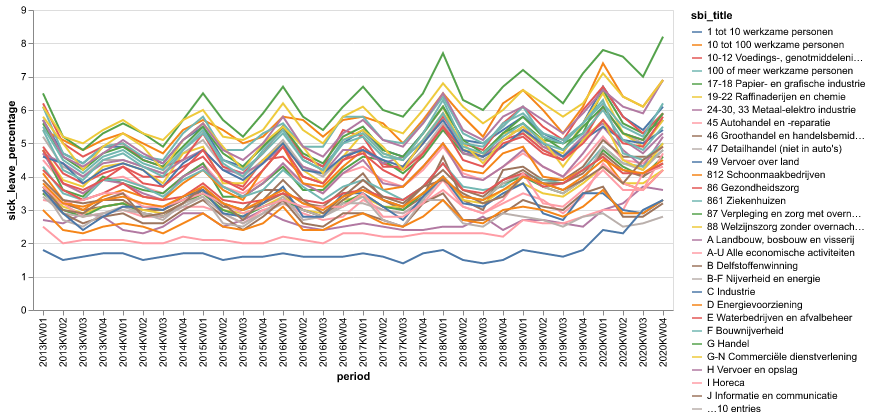

In [16]:
c = alt.Chart(slp_train).mark_line().encode(
    x='period',
    y='sick_leave_percentage',
    color='sbi_title'
)

save_graph(c, 'slp_train_all_sbi')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsgrootte', 'Totaal'])]).mark_line().encode(
    x='period',
    y='sick_leave_percentage',
    color='sbi_title'
)

save_graph(c, 'slp_train_sbi_size')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfssector', 'Totaal'])]).mark_line().encode(
    x='period',
    y='sick_leave_percentage',
    color='sbi_title'
)

save_graph(c, 'slp_train_sbi_sector')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsklasse', 'Totaal'])]).mark_line().encode(
    x='period',
    y='sick_leave_percentage',
    color='sbi_title'
)

save_graph(c, 'slp_train_sbi_klasse')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfstak', 'Totaal'])]).mark_line().encode(
    x='period',
    y='sick_leave_percentage',
    color='sbi_title'
)

save_graph(c, 'slp_train_sbi_tak')
c

In [ ]:
c = alt.Chart(slp_train).mark_boxplot().encode(
    x='period',
    y='sick_leave_percentage',
)

save_graph(c, 'slp_train_boxplot')
c

In [ ]:
slp_train_total = slp_train[slp_train.sbi == 'T001081']

c = alt.Chart(slp_train_total).mark_line().encode(
    x='period_quarter_number',
    y='sick_leave_percentage',
    color='period_year'
).properties(title='Seasonality of T001081 sick leave %')

save_graph(c, 'slp_train_total_seasonality')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsgrootte', 'Totaal'])]).mark_line().encode(
    x='period_quarter_number',
    y='sick_leave_percentage',
    color='period_year',
).facet(
    facet='sbi_title',
    columns=4
)

save_graph(c, 'slp_train_sbi_size_year')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsgrootte', 'Totaal'])]).mark_line().encode(
    x='period_year',
    y='sick_leave_percentage',
    color='sbi_title',
).facet(
    facet='period_quarter_number',
    columns=4
)

save_graph(c, 'slp_train_sbi_year_size')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfssector'])]).mark_line().encode(
    x='period_quarter_number',
    y='sick_leave_percentage',
    color='period_year',
).facet(
    facet='sbi_title',
    columns=4
)

save_graph(c, 'slp_train_sbi_sector_year')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfssector', 'Totaal'])]).mark_line().encode(
    x='period_year',
    y='sick_leave_percentage',
    color='sbi_title',
).facet(
    facet='period_quarter_number',
    columns=4
)

save_graph(c, 'slp_train_sbi_sector_year_size')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsklasse'])]).mark_line().encode(
    x='period_quarter_number',
    y='sick_leave_percentage',
    color='period_year',
).facet(
    facet='sbi_title',
    columns=5
)

save_graph(c, 'slp_train_sbi_klasse_year')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfsklasse', 'Totaal'])]).mark_line().encode(
    x='period_year',
    y='sick_leave_percentage',
    color='sbi_title',
).facet(
    facet='period_quarter_number',
    columns=4
)

save_graph(c, 'slp_train_sbi_klasse_quarter')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfstak'])]).mark_line().encode(
    x='period_quarter_number',
    y='sick_leave_percentage',
    color='period_year',
).facet(
    facet='sbi_title',
    columns=6
)

save_graph(c, 'slp_train_sbi_tak_year')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.category_group_title.isin(['Bedrijfstak', 'Totaal'])]).mark_line().encode(
    x='period_year',
    y='sick_leave_percentage',
    color='sbi_title',
).facet(
    facet='period_quarter_number',
    columns=4
)

save_graph(c, 'slp_train_sbi_tak_quarter')
c

In [ ]:
c = alt.Chart(slp_train).mark_point().encode(
    x=alt.X(alt.repeat("column"), type='ordinal'),
    y='sick_leave_percentage',
    color='period_year'
).repeat(
    column=['period_quarter_number']
).properties(
    title='Seasonality sick leave % (all categories)'
)

save_graph(c, 'slp_train_seasonality_all_sbi')
c

In [ ]:
c = alt.Chart(slp_train_total).mark_point().encode(
    x=alt.X(alt.repeat("column"), type='ordinal'),
    y='sick_leave_percentage',
    color='period_year'
).repeat(
    column=['period_quarter_number']
).properties(
    title='Seasonality of T001081 sick leave %'
)

save_graph(c, 'slp_train_total_seasonality_point')
c

In [ ]:
c = alt.Chart(slp_train[slp_train.period_quarter_number == 1]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train[slp_train.period_quarter_number == 2]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train[slp_train.period_quarter_number == 3]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train[slp_train.period_quarter_number == 4]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
)

save_graph(c, 'slp_train_seasonality_all_sbi_point_per_quarter')
c

In [ ]:
c = alt.Chart(slp_train_total[slp_train_total.period_quarter_number == 1]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train_total[slp_train_total.period_quarter_number == 2]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train_total[slp_train_total.period_quarter_number == 3]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
) | alt.Chart(slp_train_total[slp_train_total.period_quarter_number == 4]).mark_point().encode(
    x='period',
    y='sick_leave_percentage',
    color='period_year'
)

save_graph(c, 'slp_train_total_seasonality_point_per_quarter')
c

In [ ]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i, lag in enumerate(range(1, 9)):
    lag_plot(slp_train_total.sick_leave_percentage, lag=lag, ax=axes[i // 4, i % 4])

save_fig(plt, 'slp_train_total_lag_plot')
plt.show()
import math

start_lag = 0
lag_length = 21

lagged_auto_correlation = pd.DataFrame()
lagged_auto_correlation['lag'] = range(start_lag, lag_length)

white_noise_border = 1.96 / math.sqrt(len(slp_train_total.sick_leave_percentage))

wn_border = pd.DataFrame()
wn_border['lag'] = range(start_lag - 1, lag_length + 1)
wn_border['pos_white_noise_border'] = [white_noise_border for _ in range(start_lag - 1, lag_length + 1)]
wn_border['neg_white_noise_border'] = [-white_noise_border for _ in range(start_lag - 1, lag_length + 1)]

lagged_auto_correlation['auto_correlation'] = [slp_train_total.sick_leave_percentage.autocorr(lag=lag) for lag in
                                               lagged_auto_correlation['lag']]

c = alt.Chart(lagged_auto_correlation).mark_bar().encode(
    x='lag',
    y='auto_correlation',
) + alt.Chart(wn_border).mark_line(strokeDash=[1, 1]).encode(
    x='lag',
    y='pos_white_noise_border',
) + alt.Chart(wn_border).mark_line(strokeDash=[1, 1]).encode(
    x='lag',
    y='neg_white_noise_border'
)

save_graph(c, 'slp_train_total_auto_correlation')
c

In [ ]:
moving_average = pd.DataFrame()

moving_average['quarter'] = slp_train_total.period
moving_average['sick'] = slp_train_total.sick_leave_percentage

for window in range(3, 16, 2):
    moving_average[f'{window}-MA'] = slp_train_total.sick_leave_percentage.rolling(window, center=True).mean()

moving_average

In [ ]:
charts = [alt.Chart(moving_average).mark_line().encode(x='quarter', y='sick')]

for window in range(3, 16, 2):
    charts.append(alt.Chart(moving_average).mark_line().encode(x='quarter', y=f'{window}-MA'))

c = alt.vconcat(*charts)
save_graph(c, 'slp_train_total_moving_average')
c

In [ ]:
from statsmodels.tsa.seasonal import STL

slp_series = slp_train_total.sick_leave_percentage
slp_series.index = slp_train_total.period
slp_series

In [ ]:
plt.rc("font", size=6)
stl = STL(slp_series, period=4)
res = stl.fit()

fig = res.plot()
fig.autofmt_xdate()
save_fig(fig, 'slp_train_total_STL_plot')
fig

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(slp_series, lags=15, alpha=0.1)
save_fig(plt, 'slp_train_total_pacf')
plt.show()